In [1]:
import time
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import dataset

from sklearn.metrics import confusion_matrix
from datetime import timedelta
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
from model import *
from utils import *
from DataSet import *

Reading time: 0:00:02.422139


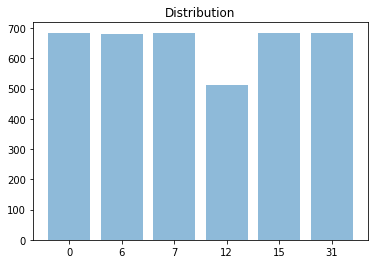

2359 786 788


In [3]:
labels = get_labels('D:/Download/dataset/vip/zach_cont_gest_1/data.txt')
imgs, labels = get_data(labels, 'D:/Download/dataset/vip/zach_cont_gest_1/*.png')
imgs, labels = subsampling(imgs, labels)
get_distribution(labels, plot=True)
train_set = read_data_sets(imgs, labels).train
val_set = read_data_sets(imgs, labels).validation
test_set = read_data_sets(imgs, labels).test

In [4]:
# Create some wrappers for simplicity
def weight_variable(shape):
    # weight placeholder wrapper
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

def bias_variable(shape):
    # bias placeholder wrapper
    return tf.Variable(tf.constant(0.01, shape=shape))

In [5]:
def conv2d_layer(x, W, b, act, strides1=1, strides2=1, name='conv', padding='SAME'):
    # Conv2D wrapper, with bias and relu activation
    with tf.name_scope('conv2d'):
        conv = tf.nn.conv2d(x, W, strides=[1, strides1, strides2, 1], padding=padding)
        conv = act(conv + b)
    return conv

def maxpool2d_layer(x, strides1=2, strides2=2, padding='SAME'):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, strides1, strides2, 1], strides=[1, strides1, strides2, 1],
                          padding=padding)

def dropout_layer(x, name='dropout', keep_prob=0.5):
    # Dropout wrapper
    return tf.nn.dropout(x, keep_prob)

def flatten_layer(x):
    # Flatten wrapper
    layer_shape = x.get_shape()
    num_features = layer_shape[1:4].num_elements()
    flat = tf.reshape(x, [-1, num_features])
    return flat

def fullyconnect_layer(x, W, b, act=None):
    fc = tf.matmul(x, W) + b
    if act != None:
        fc = act(fc)
    return fc

In [6]:
num_channels = 1
img_size = 128
img_size_flat = img_size * img_size * num_channels
img_shape = (img_size, img_size)
classes = np.array(list(set(labels)))
num_classes = len(classes)
batch_size = 32
epoch_size = train_set.num_examples//32

In [7]:
def conv_net(x, weights, biases, keep_prob=0.5):
    x = tf.reshape(x, [-1, img_size, img_size, num_channels])

    conv1 = conv2d_layer(x, weights['wc1'], biases['bc1'], tf.nn.relu)
    conv1 = maxpool2d_layer(conv1, strides1=2, strides2=2)
    conv1 = dropout_layer(conv1, name='dropout1', keep_prob=0.5)
    
    conv2 = conv2d_layer(conv1, weights['wc2'], biases['bc2'], tf.nn.relu)
    conv2 = maxpool2d_layer(conv2, strides1=2, strides2=2)
    conv2 = dropout_layer(conv2, name='dropout2', keep_prob=0.5)
    
    flat = flatten_layer(conv2)
    fc1 = fullyconnect_layer(flat, weights['wfc1'], biases['bfc1'], tf.nn.relu)
    logit = fullyconnect_layer(fc1, weights['wfc2'], biases['bfc2'])
    return logit

In [26]:
def _loss(logits,labels):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels, name='xentropy')
    loss_op = tf.reduce_mean(cross_entropy, name='xentropy')
    return loss_op

def _minimize(loss, learning_rate):
    tf.summary.scalar(loss.op.name, loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = optimizer.minimize(loss, global_step=global_step)
    return train_op

def _evaluate(logits, labels):
    predicted = tf.argmax(tf.nn.softmax(logits))
    expected = tf.argmax(labels)
    correct_pred = tf.equal(predicted, expected)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    return accuracy

def _eval(sess, accuracy, x, y_true, data_set, eval_log):
    true_count = 0
    steps_per_epoch = data_set.num_examples // 32
    num_examples = steps_per_epoch * 32
    for step in range(steps_per_epoch):
        x_valid_batch, valid_cls_batch, y_valid_batch = data_set.next_batch(32)
        x_valid_batch = x_valid_batch.reshape(32, img_size_flat)
        feed_dict_validate = {x: x_valid_batch, y_true: y_valid_batch}
        true_count += sess.run(accuracy, feed_dict=feed_dict_validate)
    precision = true_count / num_examples
    result = ('  Num examples: %d  Num correct: %d  Precision : %0.04f\n' %
        (num_examples, true_count, precision))
    eval_log.write(result)

In [31]:
with tf.Graph().as_default():
    weights = {
        'wc1':weight_variable([5, 5, 1, 32]),
        'wc2':weight_variable([5, 5, 32, 64]),
        'wfc1':weight_variable([65536, 1024]),
        'wfc2':weight_variable([1024, num_classes]),
    }

    biases = {
        'bc1':bias_variable([32]),
        'bc2':bias_variable([64]),
        'bfc1':bias_variable([1024]),
        'bfc2':bias_variable([num_classes])
    }
    x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
    y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
    logits = conv_net(x, weights, biases)
    loss_op = _loss(logits, y_true)
    train_op = _minimize(loss_op, 1e-4)
    accuracy = _evaluate(logits, y_true)
    summary_op = tf.summary.merge_all()
    saver = tf.train.Saver()
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    summary_writer = tf.summary.FileWriter(logdir='log/')
    import time
    step_log = open('step_log.txt', 'w') 
    eval_log = open('eval_log.txt', 'w')
    epoch = 1
#     epoch_size
    for step in range(1, epoch_size*100):
        start_time = time.time()
        x_batch, cls_batch, y_true_batch = train_set.next_batch(batch_size)  
        x_batch = x_batch.reshape(batch_size, img_size_flat)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        _, loss_value = sess.run([train_op, loss_op], feed_dict=feed_dict_train)

        duration = time.time() - start_time
        if step % 50 == 0:
            log = ('Step %d: loss = %.2f (%.3f sec)\n' % (step, loss_value, duration))
            step_log.write(log)
            summary_str = sess.run(summary_op, feed_dict=feed_dict_train)
            summary_writer.add_summary(summary_str, step)

        if step % epoch_size == 0:
            saver.save(sess, 'log/', global_step=step)
            eval_log.write('-------------------------Step '+str(step)+'-----------------------:\n')
            eval_log.write('Training Data Eval:\n')
            start_time = time.time()
            _eval(sess, accuracy, x, y_true, train_set, eval_log)
            eval_log.write('Training Duration: %.3f sec' % (time.time() - start_time))

            eval_log.write('Validation Data Eval:\n')
            start_time = time.time()
            _eval(sess, accuracy, x, y_true, val_set, eval_log)
            eval_log.write('Validation Duration: %.3f sec' % (time.time() - start_time))

            eval_log.write('Testing Data Eval:\n')
            start_time = time.time()
            _eval(sess, accuracy, x, y_true, test_set, eval_log)
            eval_log.write('Testing Duration: %.3f sec\n' % (time.time() - start_time))
    eval_log.close()
    step_log.close()

KeyboardInterrupt: 

In [32]:
def plot_conv_weights(weights, input_channel=0):
    w = sess.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    num_filters = w.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = w[:, :, input_channel, i]
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
    plt.savefig('weights.png')

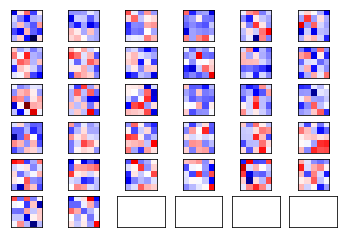

In [33]:
plot_conv_weights(weights=weights['wc1'])

In [36]:
def plot_conv_layer(layer, image):
    image = image.reshape(1, img_size_flat)
    feed_dict = {x: image}
    values = sess.run(layer, feed_dict=feed_dict)
    num_filters = values.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = values[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
    plt.savefig('conv.png')

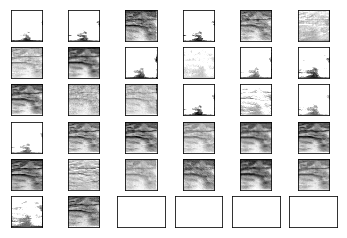

In [37]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
conv1 = conv2d_layer(x_image, weights['wc1'], biases['bc1'], tf.nn.relu)
conv1 = maxpool2d_layer(conv1, strides1=2, strides2=2)
image1 = test_set.images[0]
plot_conv_layer(layer=conv1, image=image1)